In [1]:
#Energy-Aware IDM (Eco-IDM)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize



In [4]:
def kmh_to_ms(speed_kmh):
    return speed_kmh * (1000 / 3600)

# --- Energy-aware IDM model implementation ---
def eco_idm_acceleration(v, s, delta_v, params):
    v0, T, s0, a_max, b, lambda_e = params
    s_star = s0 + v * T + (v * delta_v) / (2 * np.sqrt(a_max * b))
    s_star = max(s_star, s0)

    # Standard IDM part
    acc_idm = a_max * (1 - (v / v0) ** 4 - (s_star / max(s, 1e-6)) ** 2)

    # Energy penalty (simple quadratic cost)
    energy_cost = v ** 2 + acc_idm ** 2
    acc_eco = acc_idm - lambda_e * energy_cost

    return np.clip(acc_eco, -b, a_max)

def eco_idm_model(params, time, lead_speed, initial_spacing, initial_speed):
    spacing = [initial_spacing]
    speed = [initial_speed]

    for t in range(1, len(time)):
        dt = time[t] - time[t - 1]
        v = speed[-1]
        s = spacing[-1]
        delta_v = lead_speed[t - 1] - v

        a = eco_idm_acceleration(v, s, delta_v, params)

        v_new = max(v + a * dt, 0)
        s_new = max(s + (lead_speed[t - 1] - v) * dt, 0)

        speed.append(v_new)
        spacing.append(s_new)

    return np.array(spacing), np.array(speed)

# --- Objective function (RMSE) ---
def objective_eco_idm(params, time, lead_speed, experimental_spacing, initial_spacing, initial_speed):
    simulated_spacing, _ = eco_idm_model(params, time, lead_speed, initial_spacing, initial_speed)
    rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing) ** 2))
    return rmse

# --- Calibration function ---
def calibrate_eco_idm(df, subset_duration=200, dt=0.02):
    subset_length = int(subset_duration / dt)
#     num_subsets = len(df) // subset_length
    num_subsets = 6
    subsets = [df.iloc[i * subset_length:(i + 1) * subset_length] for i in range(num_subsets)]

    best_rmse = np.inf
    best_params = None

    for i, subset in enumerate(subsets):
        print(f"\n--- Calibrating on subset {i + 1}/{num_subsets} ---")

        time = subset['Time'].values
        lead_speed = subset['Speed Leader'].values
        spacing = subset['Spacing'].values
        follower_speed = subset['Speed Follower'].values

        initial_spacing = spacing[0]
        initial_speed = follower_speed[0]

        # [v0, T, s0, a_max, b, lambda_e]
        initial_params = [25.0, 1.5, 2.0, 1.0, 1.5, 0.05]
        bounds = [(10, 40), (0.5, 3.0), (0.5, 5.0), (0.5, 3.0), (0.5, 3.0), (0.001, 1.0)]

        result = minimize(objective_eco_idm, initial_params,
                          args=(time, lead_speed, spacing, initial_spacing, initial_speed),
                          bounds=bounds, method='L-BFGS-B')

        rmse = objective_eco_idm(result.x, time, lead_speed, spacing, initial_spacing, initial_speed)
        print(f"Subset {i + 1} RMSE: {rmse:.4f}")
        print(f"Params: {result.x}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = result.x

    print("\n--- Best Calibration Results ---")
    print(f"Best Params: {best_params}")
    print(f"Best RMSE: {best_rmse:.4f}")
    return best_params

# --- Evaluation and Plotting ---
def test_and_viz_full_dataset(df, best_params,model_name,report_path, limit=None):
    # Extract relevant columns
    time = np.arange(0, len(df) * 0.02, 0.02)  # Assuming time increments by 0.02 seconds
    #     time = df['Time'].values
    lead_speed = df['Speed Leader'].values
    follow_speed = df['Speed Follower'].values
    experimental_spacing = df['Spacing'].values  # Assuming this is the spacing

    # Test the best model on the entire dataset
    # simulated_spacing_full, simulated_speed_full = idm_model(best_params, time, lead_speed, experimental_spacing[0],
    #                                                          follow_speed[0])
    simulated_spacing_full, simulated_speed_full = eco_idm_model(best_params, time, lead_speed, experimental_spacing[0],
                                                             follow_speed[0])
    rmse_full = np.sqrt(np.mean((simulated_spacing_full - experimental_spacing) ** 2))
    print("-----------------------------------------------------------------------------")
    print(f"Full dataset RMSE: {rmse_full:.4f}")

    # Apply the limit to the data
    if limit is not None:
        start, end = limit
        mask = (time >= start) & (time <= end)
        time = time[mask]
        experimental_spacing = experimental_spacing[mask]
        simulated_spacing_full = simulated_spacing_full[mask]
        follow_speed = follow_speed[mask]
        simulated_speed_full = simulated_speed_full[mask]
        lead_speed = lead_speed[mask]

    # Visualize the results
    import matplotlib.pyplot as plt

    # Plot simulated vs experimental spacing
    plt.figure(figsize=(12, 6))
    plt.plot(time, experimental_spacing, label='Experimental Spacing', color='blue', linestyle='-', linewidth=1)
    plt.plot(time, simulated_spacing_full, label='Simulated Spacing', color='red', linestyle='-', linewidth=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Spacing (m)')
    plt.title(f'Simulated vs Experimental Spacing of {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_spacing.png")
    plt.show()

    # Plot simulated vs experimental speed (including leader speed)
    plt.figure(figsize=(12, 6))
    plt.plot(time, follow_speed, label='Experimental Follower Speed', color='blue', linestyle='-', linewidth=1)
    plt.plot(time, simulated_speed_full, label='Simulated Follower Speed', color='red', linestyle='-', linewidth=1)
    plt.plot(time, lead_speed, label='Leader Speed', color='green', linestyle='-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Simulated vs Experimental Speed of {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_speed.png")
    plt.show()




--- Calibrating on subset 1/6 ---
Subset 1 RMSE: 149.8368
Params: [3.97819417e+01 5.00000000e-01 5.00000000e-01 2.09746100e+00
 9.51565305e-01 1.10522080e-02]

--- Calibrating on subset 2/6 ---
Subset 2 RMSE: 188.1505
Params: [2.60139561e+01 6.08020188e-01 8.41698000e-01 2.89198183e+00
 5.00000000e-01 1.00000000e-03]

--- Calibrating on subset 3/6 ---
Subset 3 RMSE: 29.5942
Params: [4.0000000e+01 5.0000000e-01 5.0000000e-01 3.0000000e+00 5.2794012e-01
 1.0000000e-03]

--- Calibrating on subset 4/6 ---
Subset 4 RMSE: 33.9854
Params: [3.01703472e+01 5.00000000e-01 5.00000000e-01 3.00000000e+00
 1.82194165e+00 1.00000000e-03]

--- Calibrating on subset 5/6 ---
Subset 5 RMSE: 34.7038
Params: [2.59143632e+01 6.23805965e-01 1.66720119e+00 3.00000000e+00
 2.54599901e+00 1.00871024e-03]

--- Calibrating on subset 6/6 ---
Subset 6 RMSE: 79.8629
Params: [3.24547594e+01 6.38027000e-01 1.15059375e+00 2.92323799e+00
 5.38386048e-01 3.17525993e-03]

--- Best Calibration Results ---
Best Params: [4.

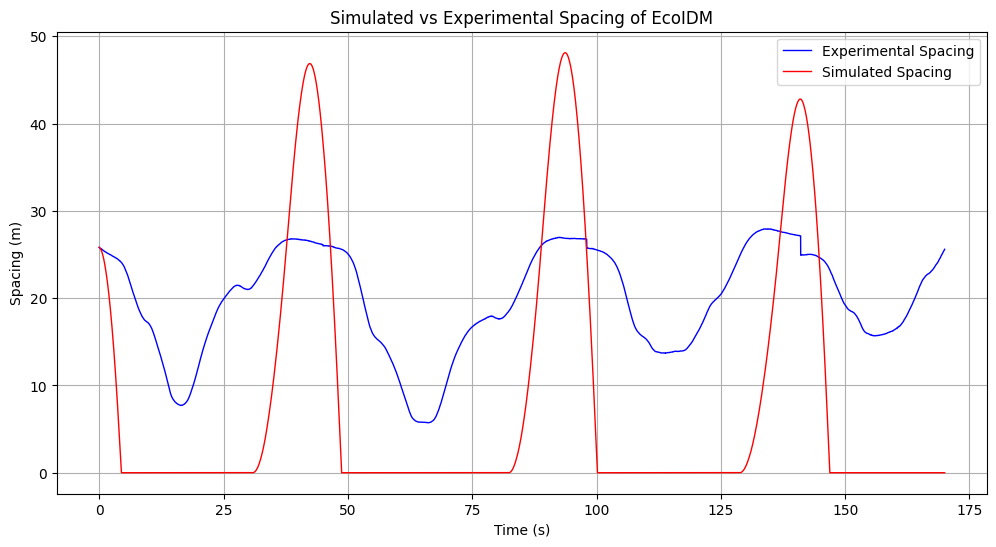

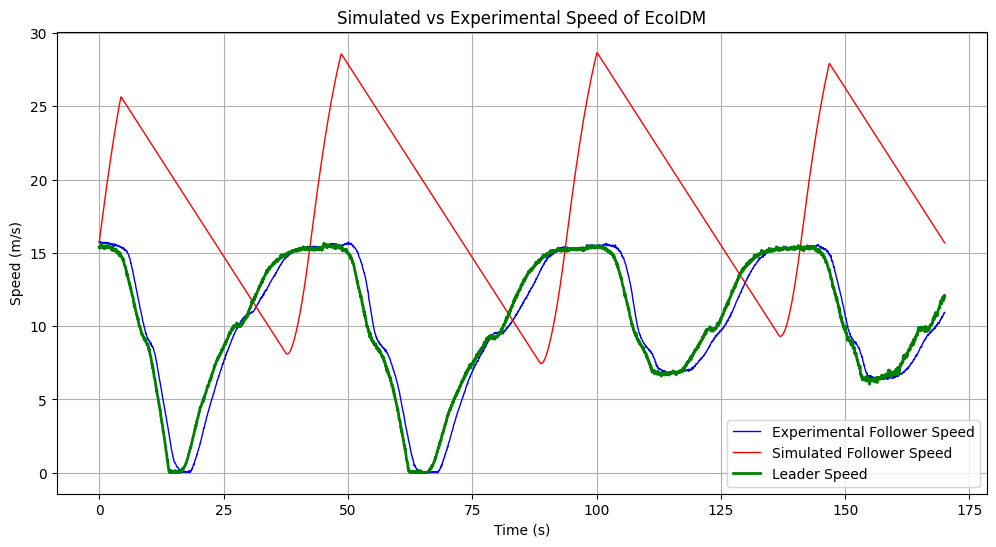

In [8]:
# --- Example Main Flow ---
if __name__ == '__main__':
    df = pd.read_csv("../data/combined_data.csv")
    df['Speed Follower'] = kmh_to_ms(df['Speed Follower'])
    df['Speed Leader'] = kmh_to_ms(df['Speed Leader'])

    medium_gap_df = df[df['gap_setting'] == 'Medium']
    best_params = calibrate_eco_idm(medium_gap_df)
    test_and_viz_full_dataset(medium_gap_df, best_params, model_name="EcoIDM", report_path="../REPORTS/EcoIDM/", limit=(0, 170))
